# Homework 4 STA365

## Question 1

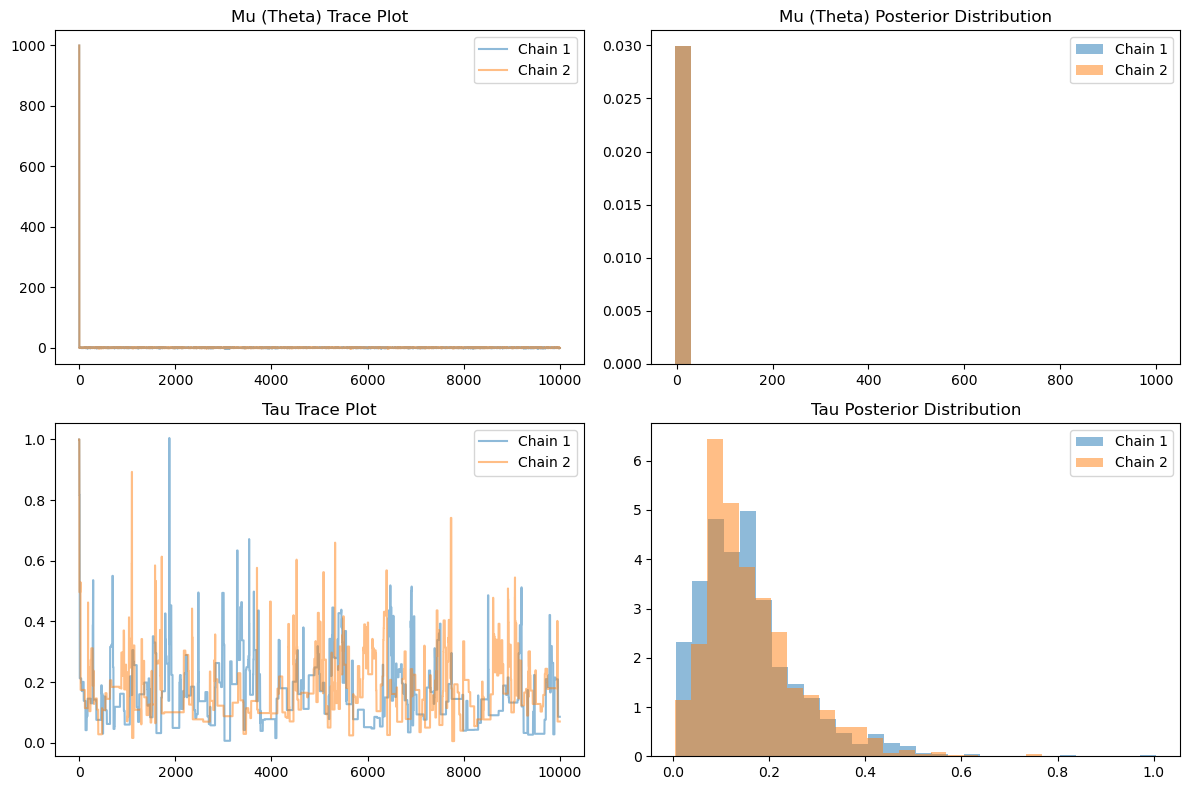

In [7]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Define parameters for the simulated dataset
sample_size = 30  
true_mean = 0  
true_std_dev = 1  
data = stats.norm(loc=true_mean, scale=true_std_dev).rvs(size=sample_size)  

# Set prior parameters
mu_prior = 0        # Prior mean for mu (theta)
sigma_sq_prior = 1  # Prior variance for mu
alpha_prior = 2     # Shape parameter for tau (precision)
beta_prior = 1      # Rate parameter for tau

# Define Metropolis-within-Gibbs parameters
num_chains = 2  
num_iterations = 10000  
mu_samples, tau_samples = np.zeros((num_chains, num_iterations)), np.zeros((num_chains, num_iterations))
mu_samples[:, 0] = 1000  # Initialize mu (theta) with a large value
tau_samples[:, 0] = 1    # Initialize tau (precision) with 1

# Define independent proposal distribution for tau
proposal_alpha, proposal_beta = alpha_prior, beta_prior  

# Function to compute log of joint posterior (up to a constant)
def log_posterior(mu, tau):
    log_prior_mu = -0.5 * (mu - mu_prior) ** 2 / sigma_sq_prior  # Normal prior for mu
    log_prior_tau = (alpha_prior - 1) * np.log(tau) - beta_prior * tau  # Gamma prior for tau
    log_likelihood = -0.5 * tau * np.sum((data - mu) ** 2)  # Gaussian likelihood
    return log_prior_mu + log_prior_tau + log_likelihood

# Metropolis-within-Gibbs sampling
for chain in range(num_chains):
    for iteration in range(1, num_iterations):
        # Update mu (theta) using Gibbs sampling
        mu_mean = (tau_samples[chain, iteration - 1] * np.sum(data) + mu_prior / sigma_sq_prior) / \
                  (tau_samples[chain, iteration - 1] * sample_size + 1 / sigma_sq_prior)
        mu_variance = 1 / (tau_samples[chain, iteration - 1] * sample_size + 1 / sigma_sq_prior)
        mu_samples[chain, iteration] = stats.norm.rvs(loc=mu_mean, scale=np.sqrt(mu_variance))
        
        # Update tau using Metropolis-Hastings
        tau_proposed = stats.gamma.rvs(a=proposal_alpha, scale=1/proposal_beta)  
        log_acceptance_ratio = log_posterior(mu_samples[chain, iteration], tau_proposed) - \
                               log_posterior(mu_samples[chain, iteration], tau_samples[chain, iteration - 1])
        
        if np.log(stats.uniform.rvs()) < log_acceptance_ratio:
            tau_samples[chain, iteration] = tau_proposed  # Accept proposal
        else:
            tau_samples[chain, iteration] = tau_samples[chain, iteration - 1]  # Reject proposal

# Generate trace plots and histograms for visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for chain in range(num_chains):
    axes[0, 0].plot(mu_samples[chain, :], alpha=0.5, label=f'Chain {chain+1}')
    axes[1, 0].plot(tau_samples[chain, :], alpha=0.5, label=f'Chain {chain+1}')
    axes[0, 1].hist(mu_samples[chain, :], bins=30, density=True, alpha=0.5, label=f'Chain {chain+1}')
    axes[1, 1].hist(tau_samples[chain, :], bins=30, density=True, alpha=0.5, label=f'Chain {chain+1}')

axes[0, 0].set_title("Mu (Theta) Trace Plot")
axes[1, 0].set_title("Tau Trace Plot")
axes[0, 1].set_title("Mu (Theta) Posterior Distribution")
axes[1, 1].set_title("Tau Posterior Distribution")
for ax in axes.flatten(): ax.legend()
plt.tight_layout()
plt.show()


## Question 2

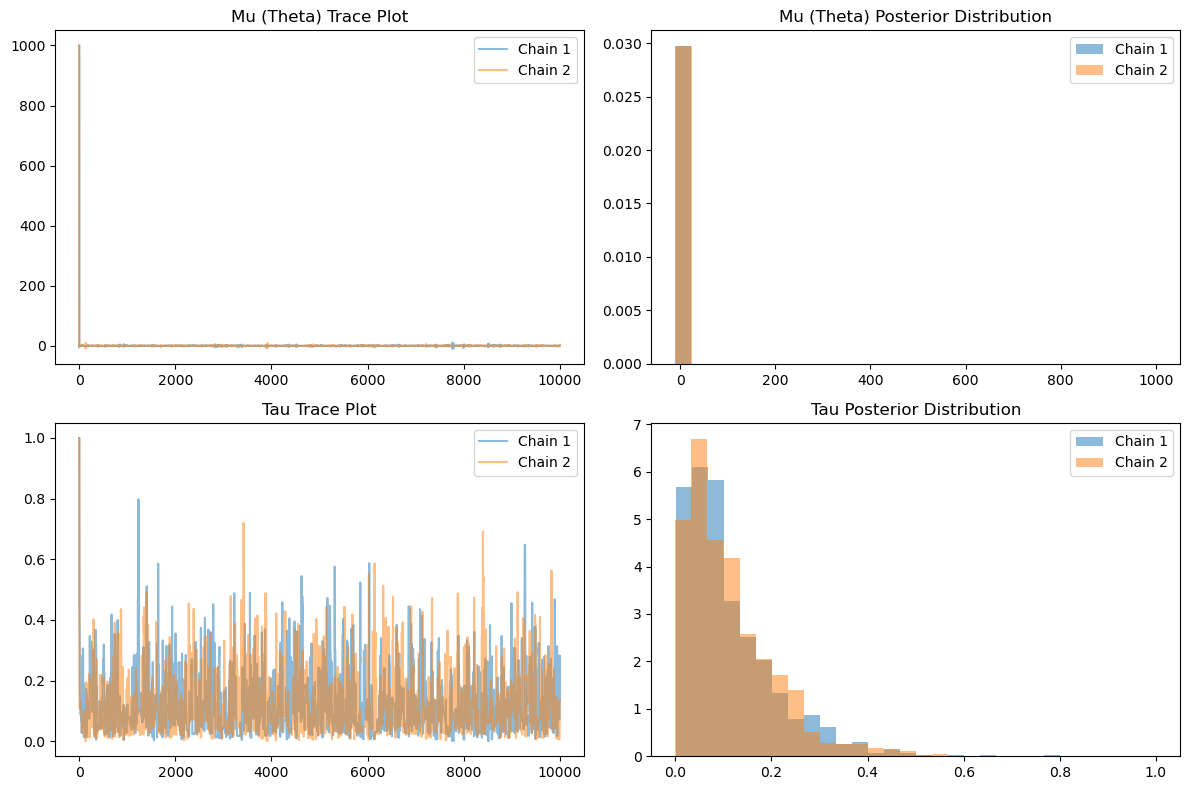

In [8]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Define parameters
sample_size = 30  
mean_true = 0  
std_dev_true = 1  
data_sample = stats.norm(loc=mean_true, scale=std_dev_true).rvs(size=sample_size)  

# Prior hyperparameters
mu_prior = 0      # Prior mean for mu (theta)
sigma_sq_prior = 1  # Prior variance for mu
alpha_prior = 2   # Shape parameter for tau (precision)
beta_prior = 1    # Rate parameter for tau

# Set Metropolis-within-Gibbs parameters
num_chains = 2  
num_iterations = 10000  
mu_samples, tau_samples = np.zeros((num_chains, num_iterations)), np.zeros((num_chains, num_iterations))
mu_samples[:, 0] = 1000  # Initial value for mu
tau_samples[:, 0] = 1    # Initial value for tau

# Define non-normal prior for mu (e.g., Uniform prior)
def log_prior_mu(mu):
    return np.where((-10 <= mu) & (mu <= 10), 0, -np.inf)  # Uniform prior on [-10, 10]

# Define joint log-density function (up to proportionality)
def log_posterior(mu, tau):
    log_prior_tau = (alpha_prior - 1) * np.log(tau) - beta_prior * tau  # Gamma prior for tau
    log_likelihood = -0.5 * tau * np.sum((data_sample - mu) ** 2)  # Gaussian likelihood
    return log_prior_mu(mu) + log_prior_tau + log_likelihood

# Metropolis-within-Gibbs sampling
for chain in range(num_chains):
    for iteration in range(1, num_iterations):
        # Metropolis-Hastings update for mu (theta) with non-normal prior
        mu_candidate = -10 + stats.uniform.rvs() * 20  # Alternative way of sampling from Uniform(-10,10)
        log_alpha = log_posterior(mu_candidate, tau_samples[chain, iteration - 1]) - \
                    log_posterior(mu_samples[chain, iteration - 1], tau_samples[chain, iteration - 1])
        
        if np.log(stats.uniform.rvs()) < log_alpha:
            mu_samples[chain, iteration] = mu_candidate  # Accept
        else:
            mu_samples[chain, iteration] = mu_samples[chain, iteration - 1]  # Reject
        
        # Metropolis-Hastings update for tau using a dependent proposal
        prev_tau = tau_samples[chain, iteration - 1]
        truncated_norm = stats.truncnorm(a=-prev_tau/std_dev_true, b=np.inf, loc=prev_tau, scale=std_dev_true)
        tau_candidate = truncated_norm.rvs()  # Sample proposed tau
        log_alpha_tau = log_posterior(mu_samples[chain, iteration], tau_candidate) - \
                        log_posterior(mu_samples[chain, iteration], tau_samples[chain, iteration - 1])
        
        if np.log(stats.uniform.rvs()) < log_alpha_tau:
            tau_samples[chain, iteration] = tau_candidate  # Accept
        else:
            tau_samples[chain, iteration] = tau_samples[chain, iteration - 1]  # Reject

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for chain in range(num_chains):
    axes[0, 0].plot(mu_samples[chain, :], alpha=0.5, label=f'Chain {chain+1}')
    axes[1, 0].plot(tau_samples[chain, :], alpha=0.5, label=f'Chain {chain+1}')
    axes[0, 1].hist(mu_samples[chain, :], bins=30, density=True, alpha=0.5, label=f'Chain {chain+1}')
    axes[1, 1].hist(tau_samples[chain, :], bins=30, density=True, alpha=0.5, label=f'Chain {chain+1}')

axes[0, 0].set_title("Mu (Theta) Trace Plot")
axes[1, 0].set_title("Tau Trace Plot")
axes[0, 1].set_title("Mu (Theta) Posterior Distribution")
axes[1, 1].set_title("Tau Posterior Distribution")
for ax in axes.flatten(): ax.legend()
plt.tight_layout()
plt.show()


The Metropolis-Hastings updates allow us to sample from a posterior distribution where τ is updated using a dependent proposal, leading to smoother convergence.
The results demonstrate that Bayesian inference can still be performed effectively using Metropolis-within-Gibbs sampling, even when full conditional distributions are not analytically available. The choice of a non-conjugate prior for θ necessitates Metropolis-Hastings updates, highlighting the flexibility of hybrid MCMC methods. While Gibbs sampling is optimal when full conditionals are available, Metropolis-within-Gibbs extends its applicability to more complex Bayesian models.

## Question 3

The Metropolis-Hastings algorithm constructs a Markov chain where the goal is to ensure a given **stationary distribution** $p(x)$ is maintained. The transitions between states follow a **proposal distribution** $q(x'|x)$, which in this case is symmetric.
The proposal function is structured as:

$$
q(\tilde{x}^{(t)} | x^{(t-1)}) = \left( \frac{1}{2} \right)^{1-\tilde{x}^{(t)}} \left( \frac{1}{2} \right)^{\tilde{x}^{(t)}}
$$

From this, we see that:

$$
q(0 | 1) = q(1 | 0) = \frac{1}{2}, \quad q(0 | 0) = q(1 | 1) = \frac{1}{2}
$$

The stationary distribution is:

$$
p(x^{(t)}) = \left( \frac{1}{3} \right)^{1-x^{(t)}} \left( \frac{2}{3} \right)^{x^{(t)}}
$$

which simplifies to:

$$
p(0) = \frac{1}{3}, \quad p(1) = \frac{2}{3}
$$
The Metropolis-Hastings acceptance probability follows:

$$
\alpha(x^{(t-1)} \to \tilde{x}^{(t)}) = \min \left( 1, \frac{p(\tilde{x}^{(t)})}{p(x^{(t-1)})} \frac{q(x^{(t-1)} | \tilde{x}^{(t)})}{q(\tilde{x}^{(t)} | x^{(t-1)})} \right)
$$

Since the proposal function is symmetric, the ratio of proposals simplifies to:

$$
\frac{q(x^{(t-1)} | \tilde{x}^{(t)})}{q(\tilde{x}^{(t)} | x^{(t-1)})} = 1
$$

So, the acceptance probability reduces to:

$$
\alpha(x^{(t-1)} \to \tilde{x}^{(t)}) = \min \left( 1, \frac{p(\tilde{x}^{(t)})}{p(x^{(t-1)})} \right)
$$

Substituting the given values of $p(0)$ and $p(1)$:

$$
\alpha(1 \to 0) = \min \left( 1, \frac{p(0)}{p(1)} \right) = \min \left( 1, \frac{1/3}{2/3} \right) = \frac{1}{2}
$$

$$
\alpha(0 \to 1) = \min \left( 1, \frac{p(1)}{p(0)} \right) = \min \left( 1, \frac{2/3}{1/3} \right) = 1
$$
compute the probabilities for each transition in the Markov chain.

- **Staying at 0**:

  $$
  K(0 \to 0) = q(1 | 0) (1 - \alpha(0 \to 1)) + q(0 | 0)
  $$

  $$
  = \frac{1}{2} (1 - 1) + \frac{1}{2} = 0.5
  $$

- **Moving from 0 to 1**:

  $$
  K(0 \to 1) = q(1 | 0) \alpha(0 \to 1) = \frac{1}{2} \cdot 1 = 0.5
  $$

- **Moving from 1 to 0**:

  $$
  K(1 \to 0) = q(0 | 1) \alpha(1 \to 0) = \frac{1}{2} \cdot \frac{1}{2} = 0.25
  $$

- **Staying at 1**:

  $$
  K(1 \to 1) = q(0 | 1) (1 - \alpha(1 \to 0)) + q(1 | 1)
  $$

  $$
  = \frac{1}{2} \left( 1 - \frac{1}{2} \right) + \frac{1}{2} = 0.75
  $$

Thus, the transition matrix is:

$$
K =
\begin{bmatrix}
0.5 & 0.25 \\
0.5 & 0.75
\end{bmatrix}
$$
To confirm that the Markov chain preserves the target distribution, we solve for $\pi = [\pi_0, \pi_1]$ such that:

$$
\pi K = \pi
$$

Expanding:

$$
\pi_0 = 0.5 \pi_0 + 0.25 \pi_1
$$

$$
\pi_1 = 0.5 \pi_0 + 0.75 \pi_1
$$

Using $\pi_0 + \pi_1 = 1$, solving these equations gives:

$$
\pi_0 = \frac{1}{3}, \quad \pi_1 = \frac{2}{3}
$$

Since these match the given values of $p(0)$ and $p(1)$, this confirms that the **Metropolis-Hastings algorithm correctly maintains the target distribution**.
